In [3]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

import dataloaders.audio_dataset as dataset
import models.inversion_v3_stacked as inversion_model
from abstract_model import AbstractModel

import torch
import torch.nn as nn

from pytorch_lightning.core.saving import load_hparams_from_yaml

import os

def _load_run(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []

        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)

        data[tag] = (np.asarray(x), np.asarray(y))
    return data

algo = "inversion_v3_sketch_identification"
data_path = "/scratch/prs392/incubator/data/LibriSpeech/speaker_identification"
checkpoint_path = f"/scratch/prs392/incubator/checkpoints/openl3_librispeech/{algo}/"
# experiment_name = "train_1000_audio_with_specific_hparams_with_emb_means_and_stds"
experiment_name = "specific_hparams"

data_paths = {}
data_paths['train'] = os.path.join(data_path, 'train')
data_paths['val'] = os.path.join(data_path, 'val')
data_paths['test'] = os.path.join(data_path, 'test')

d = os.path.join(checkpoint_path, experiment_name)
versions = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]

versions = sorted(versions)

for version in versions:
    if version == 'version_0':
        hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
        hparams_new = load_hparams_from_yaml(hparam_path)
        
from pytorch_lightning.core.saving import load_hparams_from_yaml

list_existing_hparams = []
list_of_val_loss = []

for version in versions:
    hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
    hparams_new = load_hparams_from_yaml(hparam_path)
    
#     print(hparams_new)
# #     print(_load_run(os.path.join(checkpoint_path, experiment_name, version)))
#     print(min(_load_run(os.path.join(checkpoint_path, experiment_name, version))['val_loss'][1]))
    
    if 'val_loss' in _load_run(os.path.join(checkpoint_path, experiment_name, version)):
        list_existing_hparams.append(hparams_new)
        list_of_val_loss.append(min(_load_run(os.path.join(checkpoint_path, experiment_name, version))['val_loss'][1]))

best_version, best_val_loss = versions[list_of_val_loss.index(min(list_of_val_loss))], list_of_val_loss[list_of_val_loss.index(min(list_of_val_loss))]

ckpt_path = os.path.join(checkpoint_path, experiment_name, best_version, 'checkpoints')
epoch_files = [o for o in os.listdir(ckpt_path) if os.path.isfile(os.path.join(ckpt_path,o))]
epoch_file = None
for file in epoch_files:
    if file.startswith('epoch'):
        epoch_file = file
assert epoch_file is not None

print(epoch_file)
PATH = os.path.join(ckpt_path, epoch_file)  

AudioDataset = dataset.AudioDataset
InversionV3 = inversion_model.InversionV3
# model = AbstractModel(
#     hparams=hparams_new,
#     data_paths = data_paths, 
#     dataset_model = AudioDataset,
#     model = InversionV3(), 
#     criterion = nn.MSELoss()
# )

hparams_new['num_workers'] = 0

model = AbstractModel.load_from_checkpoint(
    PATH, 
    hparams = hparams_new, 
    data_paths = data_paths, 
    dataset_model = AudioDataset,
    model = InversionV3(), 
    criterion = nn.MSELoss()
)

model = model.eval()

model.prepare_data()

epoch=5.ckpt


In [4]:
hparams_new

{'batch_size': 32,
 'emb_means': None,
 'emb_stds': None,
 'lr': 1.8363759499907522e-05,
 'lr_type': 'sgd',
 'num_frames': -1,
 'num_workers': 0,
 'return_amp': True,
 'scheduler_epoch': 4,
 'scheduler_step_size': 0.7303553459234535,
 'spec_means': None,
 'spec_stds': None,
 'test_num_audios': -1,
 'train_num_audios': -1,
 'val_num_audios': -1}

In [5]:
def SRR(y, y_hat):
    numerator = np.sum(np.square(np.abs(y)))
    denominator = np.sum(np.square(np.abs(y - y_hat)))
    return numerator/denominator

metrics = { 'SRR': SRR }

In [6]:
f = open("/scratch/prs392/incubator/results/speaker_identification/inversion_model/no_counter_measures.csv", "a")
f.write("file_name,frame,original_vs_expected,expected_vs_predicted,original_vs_predicted\n")
f.close()

In [ ]:
import tqdm
import librosa
import resampy
import random

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

total_org_vs_exp = 0
total_exp_vs_pred = 0
total_org_vs_pred = 0

model = model.cuda()

random_indexes = random.sample(range(len(model.test_dataset)), 1000)


for i in tqdm.tqdm(random_indexes):
    emb, spec, audio_prep, file, j = model.test_dataset[i]
    emb = emb.cuda()
    pred = model(emb)
    pred = pred.cpu()
    audio_prep = librosa.util.normalize(audio_prep.numpy()[0])
    
    spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]
    pred_audio = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=100,  power=0.5)
    pred_audio = librosa.util.normalize(resampy.resample(pred_audio, sr_orig=pred_audio.shape[0], sr_new=asr, filter='kaiser_best'))
    
    spec_tensor_amp = np.abs(spec[:,:,:].detach().numpy())[0,:,:]
    expected_audio = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=100,  power=0.5)
    expected_audio = librosa.util.normalize(resampy.resample(expected_audio, sr_orig=expected_audio.shape[0], sr_new=asr, filter='kaiser_best'))
    
    f = open("/scratch/prs392/incubator/results/speaker_identification/inversion_model/no_counter_measures.csv", "a")
    f.write(f"{file},{j},{SRR(audio_prep, expected_audio)},{SRR(expected_audio, pred_audio)},{SRR(audio_prep, pred_audio)}\n")
    f.close()
    

 19%|█▉        | 193/1000 [20:23<1:22:10,  6.11s/it]

In [ ]:
with open("no_counter_measures_random_test_1000_frame_indexes.pkl", "wb") as fp:   #Pickling
    pickle.dump(random_indexes, fp)

In [11]:
import tqdm
import librosa
import resampy
import random

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

total_org_vs_exp = 0
total_exp_vs_pred = 0
total_org_vs_pred = 0

model = model.cuda()


random_indexes = random.sample(range(len(model.test_dataset)), 1000)


for i in tqdm.tqdm(random_indexes):
    emb, spec, audio_prep, file, j = model.test_dataset[i]
    emb = emb.cuda()
    pred = model(emb)
    pred = pred.cpu()
    audio_prep = librosa.util.normalize(audio_prep.numpy()[0])
    
    spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]
    pred_audio = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=100,  power=0.5)
    pred_audio = librosa.util.normalize(resampy.resample(pred_audio, sr_orig=pred_audio.shape[0], sr_new=asr, filter='kaiser_best'))
    
    spec_tensor_amp = np.abs(spec[:,:,:].detach().numpy())[0,:,:]
    expected_audio = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=100,  power=0.5)
    expected_audio = librosa.util.normalize(resampy.resample(expected_audio, sr_orig=expected_audio.shape[0], sr_new=asr, filter='kaiser_best'))
    
#     print(SRR(audio_prep, pred_audio))
#     print(SRR(expected_audio, pred_audio))
#     print(audio_prep.shape, pred_audio.shape)
    
    total_org_vs_exp += SRR(audio_prep, expected_audio)
    total_exp_vs_pred += SRR(expected_audio, pred_audio)
    total_org_vs_pred += SRR(audio_prep, pred_audio)

    
#     break
    

 32%|███▏      | 315/1000 [30:49<1:07:02,  5.87s/it]


KeyboardInterrupt: 

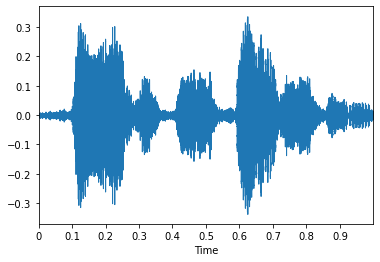

In [14]:
import librosa.display
librosa.display.waveplot(librosa.util.normalize(audio_prep), sr=48000)


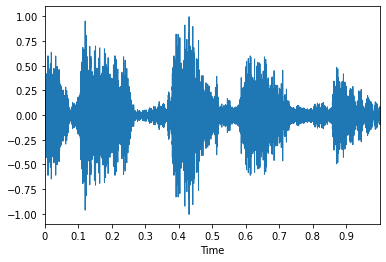

In [18]:
librosa.display.waveplot(librosa.util.normalize(expected_audio), sr=48000)

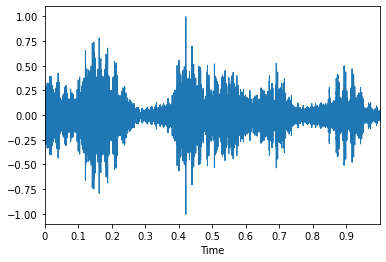

In [17]:
librosa.display.waveplot(librosa.util.normalize(pred_audio), sr=48000)

In [ ]:
model = MyLightingModule.load_from_checkpoint(PATH)